# TRAINING

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import glob
import cv2
import zipfile
import jupyter_black

from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.layers import (
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    Flatten,
    Rescaling,
    Input,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing import image

# from plot_keras_history import show_history, plot_history

In [2]:
%load_ext jupyter_black

In [3]:
# Le dossier des images d'entraînement qui contient un dossier C et un dossier NC
DATA = r"C:\Users\John\Desktop\LFP 070724\data\train_missing_stud_LH07"

In [4]:
# Choix défaut

# NOM_DEFAUT = "LH03_missing_tape"
# NOM_DEFAUT = "LH03_tape"
# NOM_DEFAUT = "LH03_double_tape"
# NOM_DEFAUT = "LH04_double_tape"
# NOM_DEFAUT = "LH04_short_tape"
# NOM_DEFAUT = "LH05_tilted_tape"
# NOM_DEFAUT = "RH07_missing_tape"
NOM_DEFAUT = "LH07_missing_stud"

In [5]:
match = {
    "LH03_missing_tape": [
        "LH",
        "_03_",
        "model_missing_tape_LH03",
        0.09,
        0.18,
        0.05,
        0.25,
    ],
    "LH03_double_tape": [
        "LH",
        "_03_",
        "model_double_tape_LH03",
        0.07,
        0.15,
        0.05,
        0.15,
    ],
    "LH03_tape": ["LH", "_03_", "model_tape_LH03", 0.09, 0.18, 0.05, 0.25],
    "LH04_double_tape": ["LH", "_04_", "model_double_tape_LH04", 0.28, 0.35, 0, 0.07],
    "LH04_short_tape": ["LH", "_04_", "model_short_tape_LH04", 0.3, 0.4, 0, 0.22],
    "LH05_tilted_tape": ["LH", "_05_", "model_tilted_tape_LH05", 0.4, 0.49, 0.78, 1],
    "RH07_missing_tape": [
        "RH",
        "_07_",
        "model_missing_tape_RH07",
        0.62,
        0.73,
        0.78,
        0.91,
    ],
    "LH07_missing_stud": [
        "LH",
        "_07_",
        "model_missing_stud_LH07",
        0.57,
        0.6,
        0.31,
        0.37,
    ],
}

In [6]:
PREFIX = match[NOM_DEFAUT][0]
SUFFIX = match[NOM_DEFAUT][1]
MODEL = match[NOM_DEFAUT][2]
COEF_X1 = match[NOM_DEFAUT][3]
COEF_X2 = match[NOM_DEFAUT][4]
COEF_Y1 = match[NOM_DEFAUT][5]
COEF_Y2 = match[NOM_DEFAUT][6]

In [7]:
# shutil.rmtree("/kaggle/working/", ignore_errors=True)

In [8]:
LISTE_DEFAUT = os.listdir(os.path.join(DATA, "NC"))

CPU times: total: 281 ms
Wall time: 281 ms


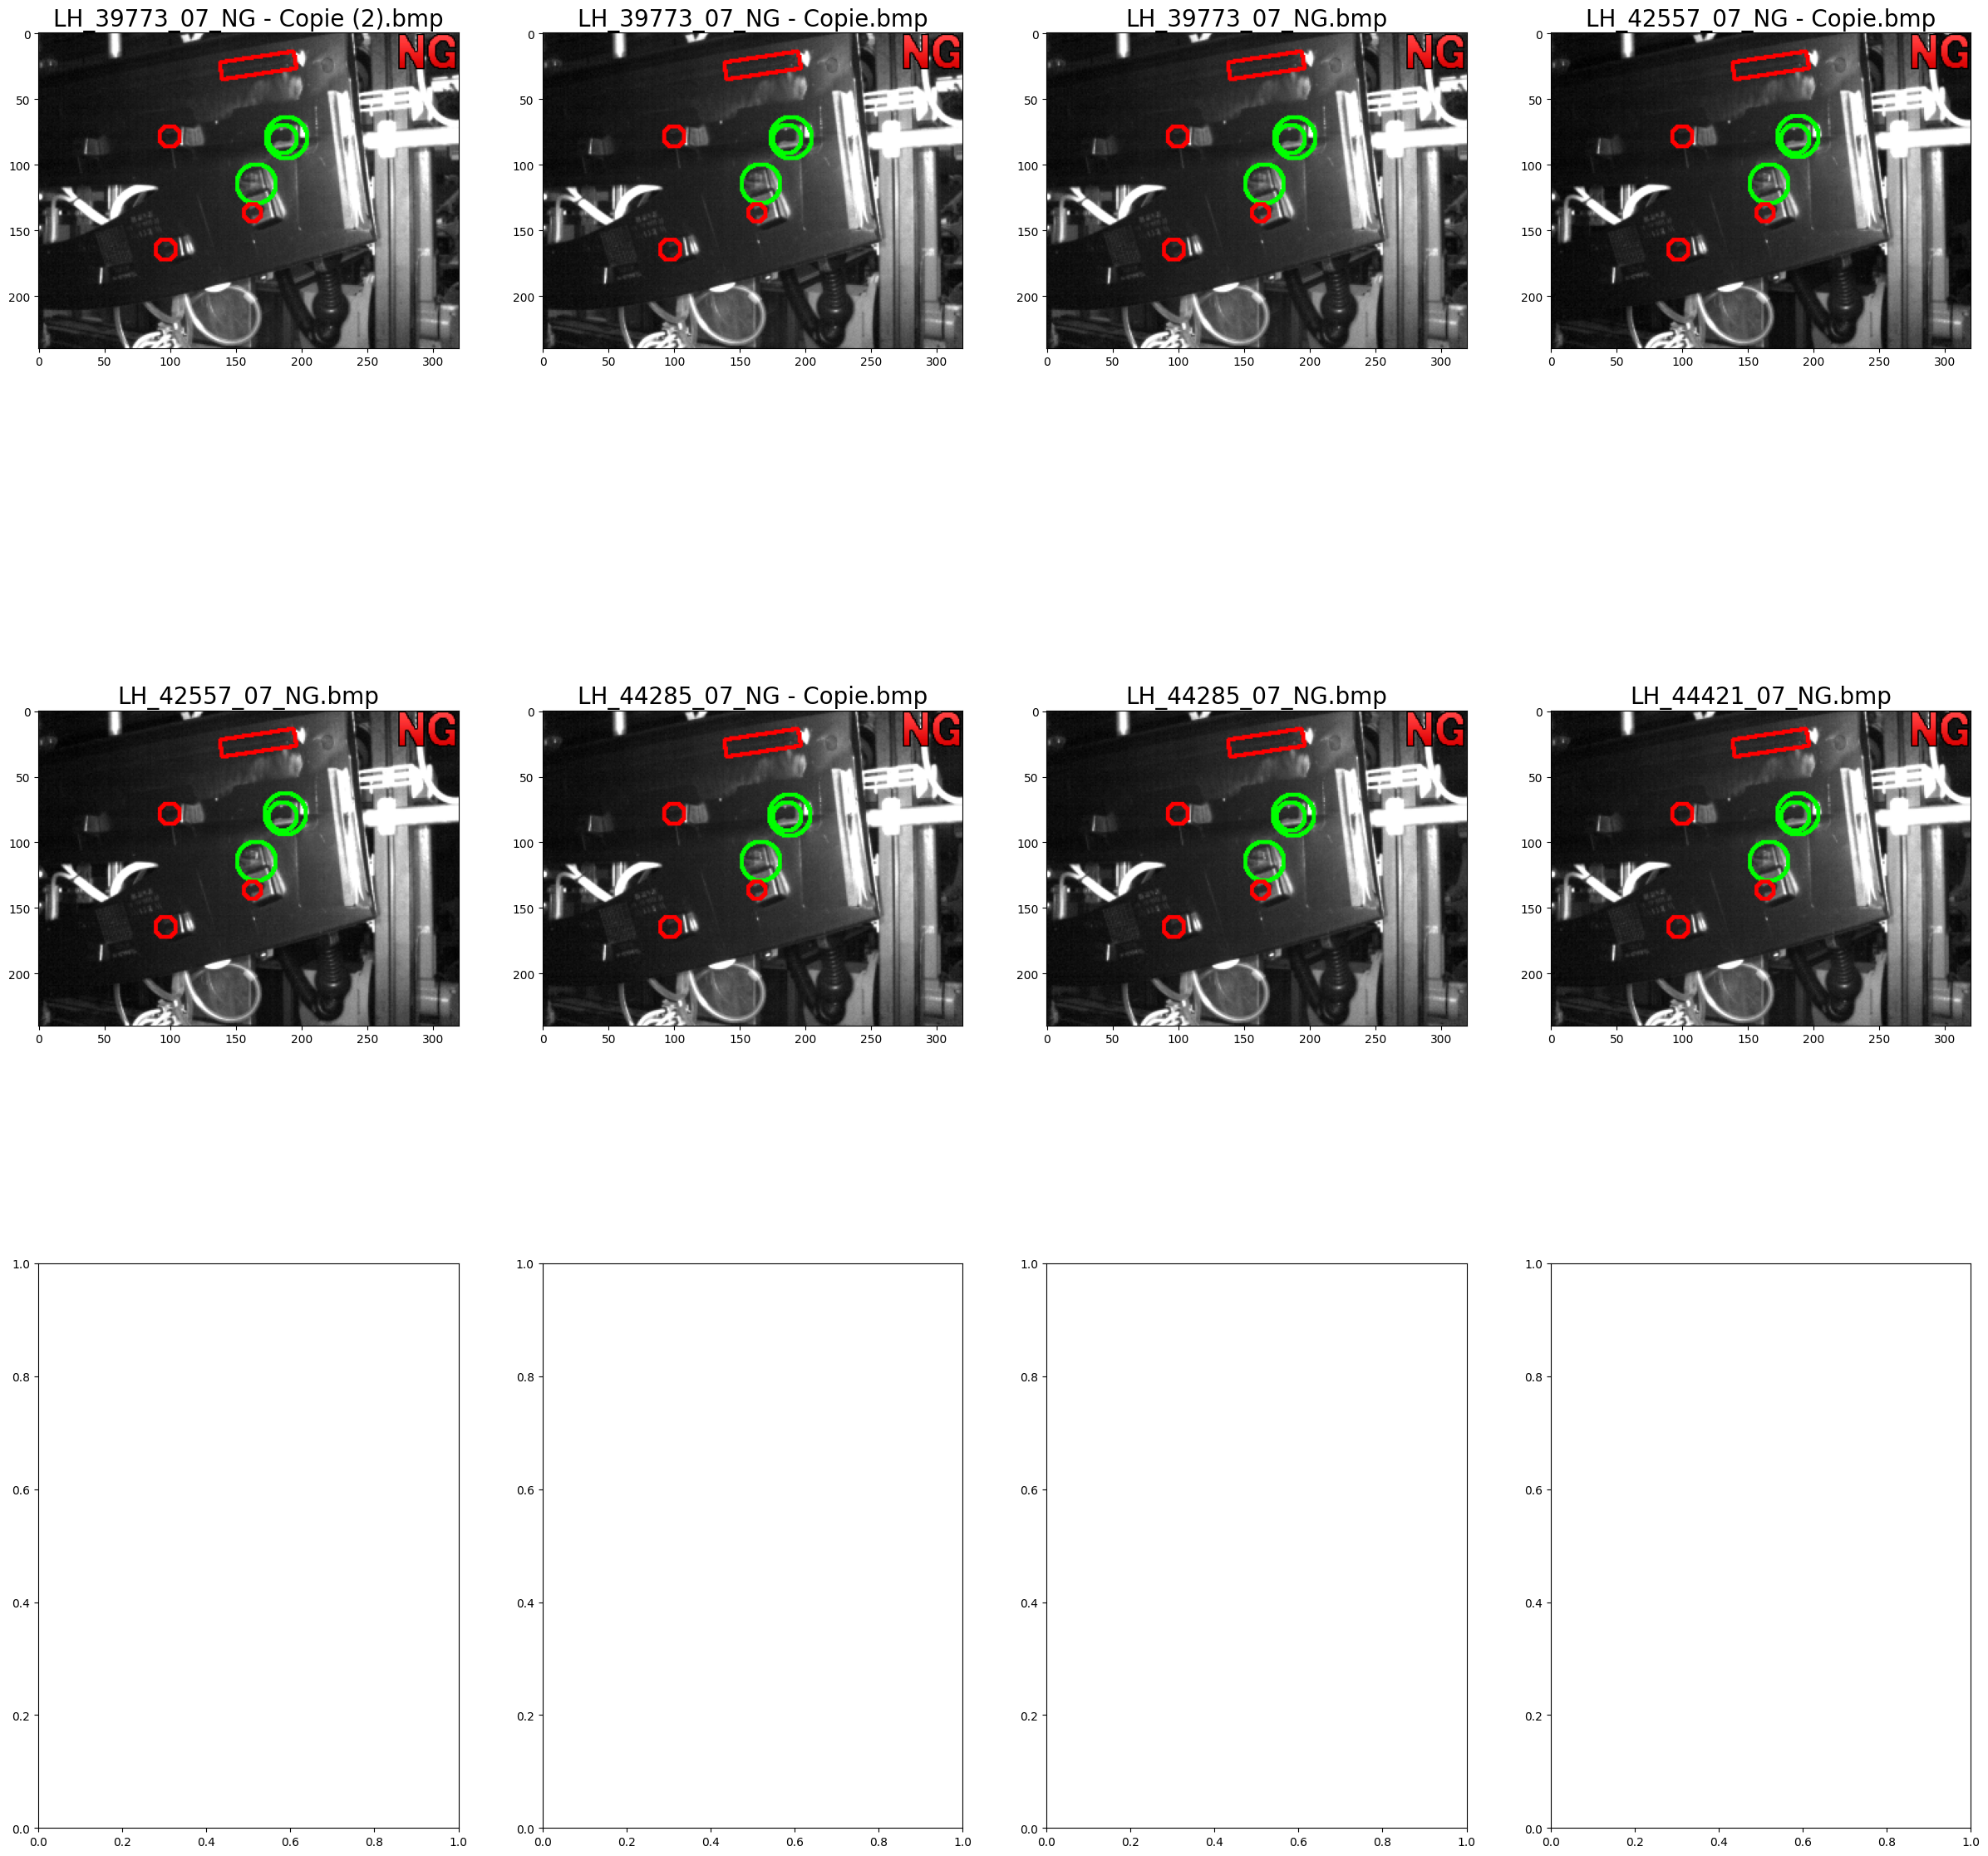

In [9]:
%%time
# Visualisons les images de défaut pour l'entraînement
fig, ax = plt.subplots(1 + len(LISTE_DEFAUT) // 4, 4, figsize=(30, 30))
ax = ax.flatten()
for idx, path in enumerate(LISTE_DEFAUT):
    img = os.path.join(DATA, "NC", path)
    # assert img est une image
    ax[idx].imshow(plt.imread(img))
    ax[idx].set_title(path, fontsize=20)

# Approche avec préparation des images
on va extraire un morceau des images et on va entraîner le modèle sur ces morceaux.

on définit les bords de la fenêtre à extraire sur chaque image.

In [10]:
img = plt.imread(glob.glob(f"{DATA}/NC/*")[0])
taille_image = img.shape
taille_image

(240, 320, 3)

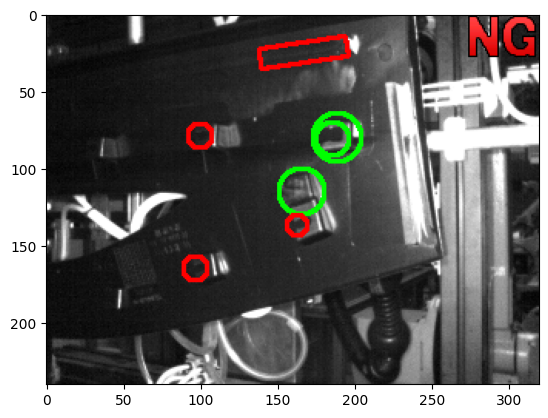

In [11]:
plt.imshow(img)

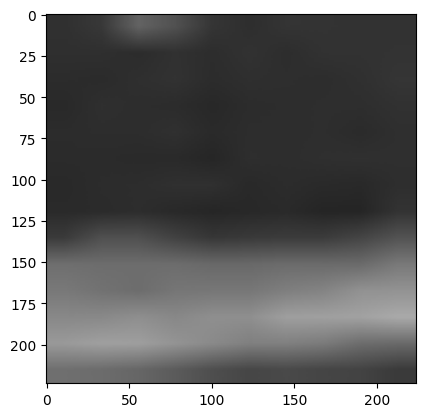

In [12]:
img = plt.imread(glob.glob(f"{DATA}/C/*")[0])
img = plt.imread(glob.glob(f"{DATA}/NC/*")[0])
y_start, y_end = int(taille_image[0] * COEF_Y1), int(taille_image[0] * COEF_Y2)
x_start, x_end = int(taille_image[1] * COEF_X1), int(taille_image[1] * COEF_X2)
img_cropped = img[y_start:y_end, x_start:x_end]
img_cropped = cv2.resize(img_cropped, (224, 224))
plt.imshow(img_cropped)

## Création de nouveaux dossiers d'entraînement et de validation avec les images préparées

In [13]:
# crée un dossier dir_crop à partir du dossier dir avec des sous dossiers "C" et "NC" qui reprend les images de dir en les réduisant
def preparation_image(dir_source, dir_crop):

    for img in glob.glob(
        os.path.join(dir_source, "**", f"{PREFIX}*{SUFFIX}*.bmp"), recursive=True
    ):
        # Load the image
        image_path = img
        image = cv2.imread(image_path)

        # Crop the window
        cropped_image = image[y_start:y_end, x_start:x_end]

        # Créer le dossier s'il n'existe pas
        dossier = dir_crop
        os.makedirs(dossier, exist_ok=True)

        # Chemin d'accès pour sauvegarder l'image préparée
        cropped_image_path = os.path.join(dossier, os.path.basename(img))

        # Sauvegarder l'image au même nom que l'image d'origine
        cv2.imwrite(cropped_image_path, cropped_image)

In [14]:
%%time
# 13s
# Définir les chemins vers les répertoires d'entraînement et de validation sur les morceaux d'image
DATA_CROP_TRAIN = "../data/DATA_CROP_TRAIN"

os.makedirs("../data/DATA_CROP_TRAIN/C", exist_ok=True)
os.makedirs("../data/DATA_CROP_TRAIN/NC", exist_ok=True)

preparation_image(os.path.join(DATA, "C"), os.path.join(DATA_CROP_TRAIN, "C"))
preparation_image(os.path.join(DATA, "NC"), os.path.join(DATA_CROP_TRAIN, "NC"))

CPU times: total: 46.9 ms
Wall time: 28 ms


CPU times: total: 344 ms
Wall time: 316 ms


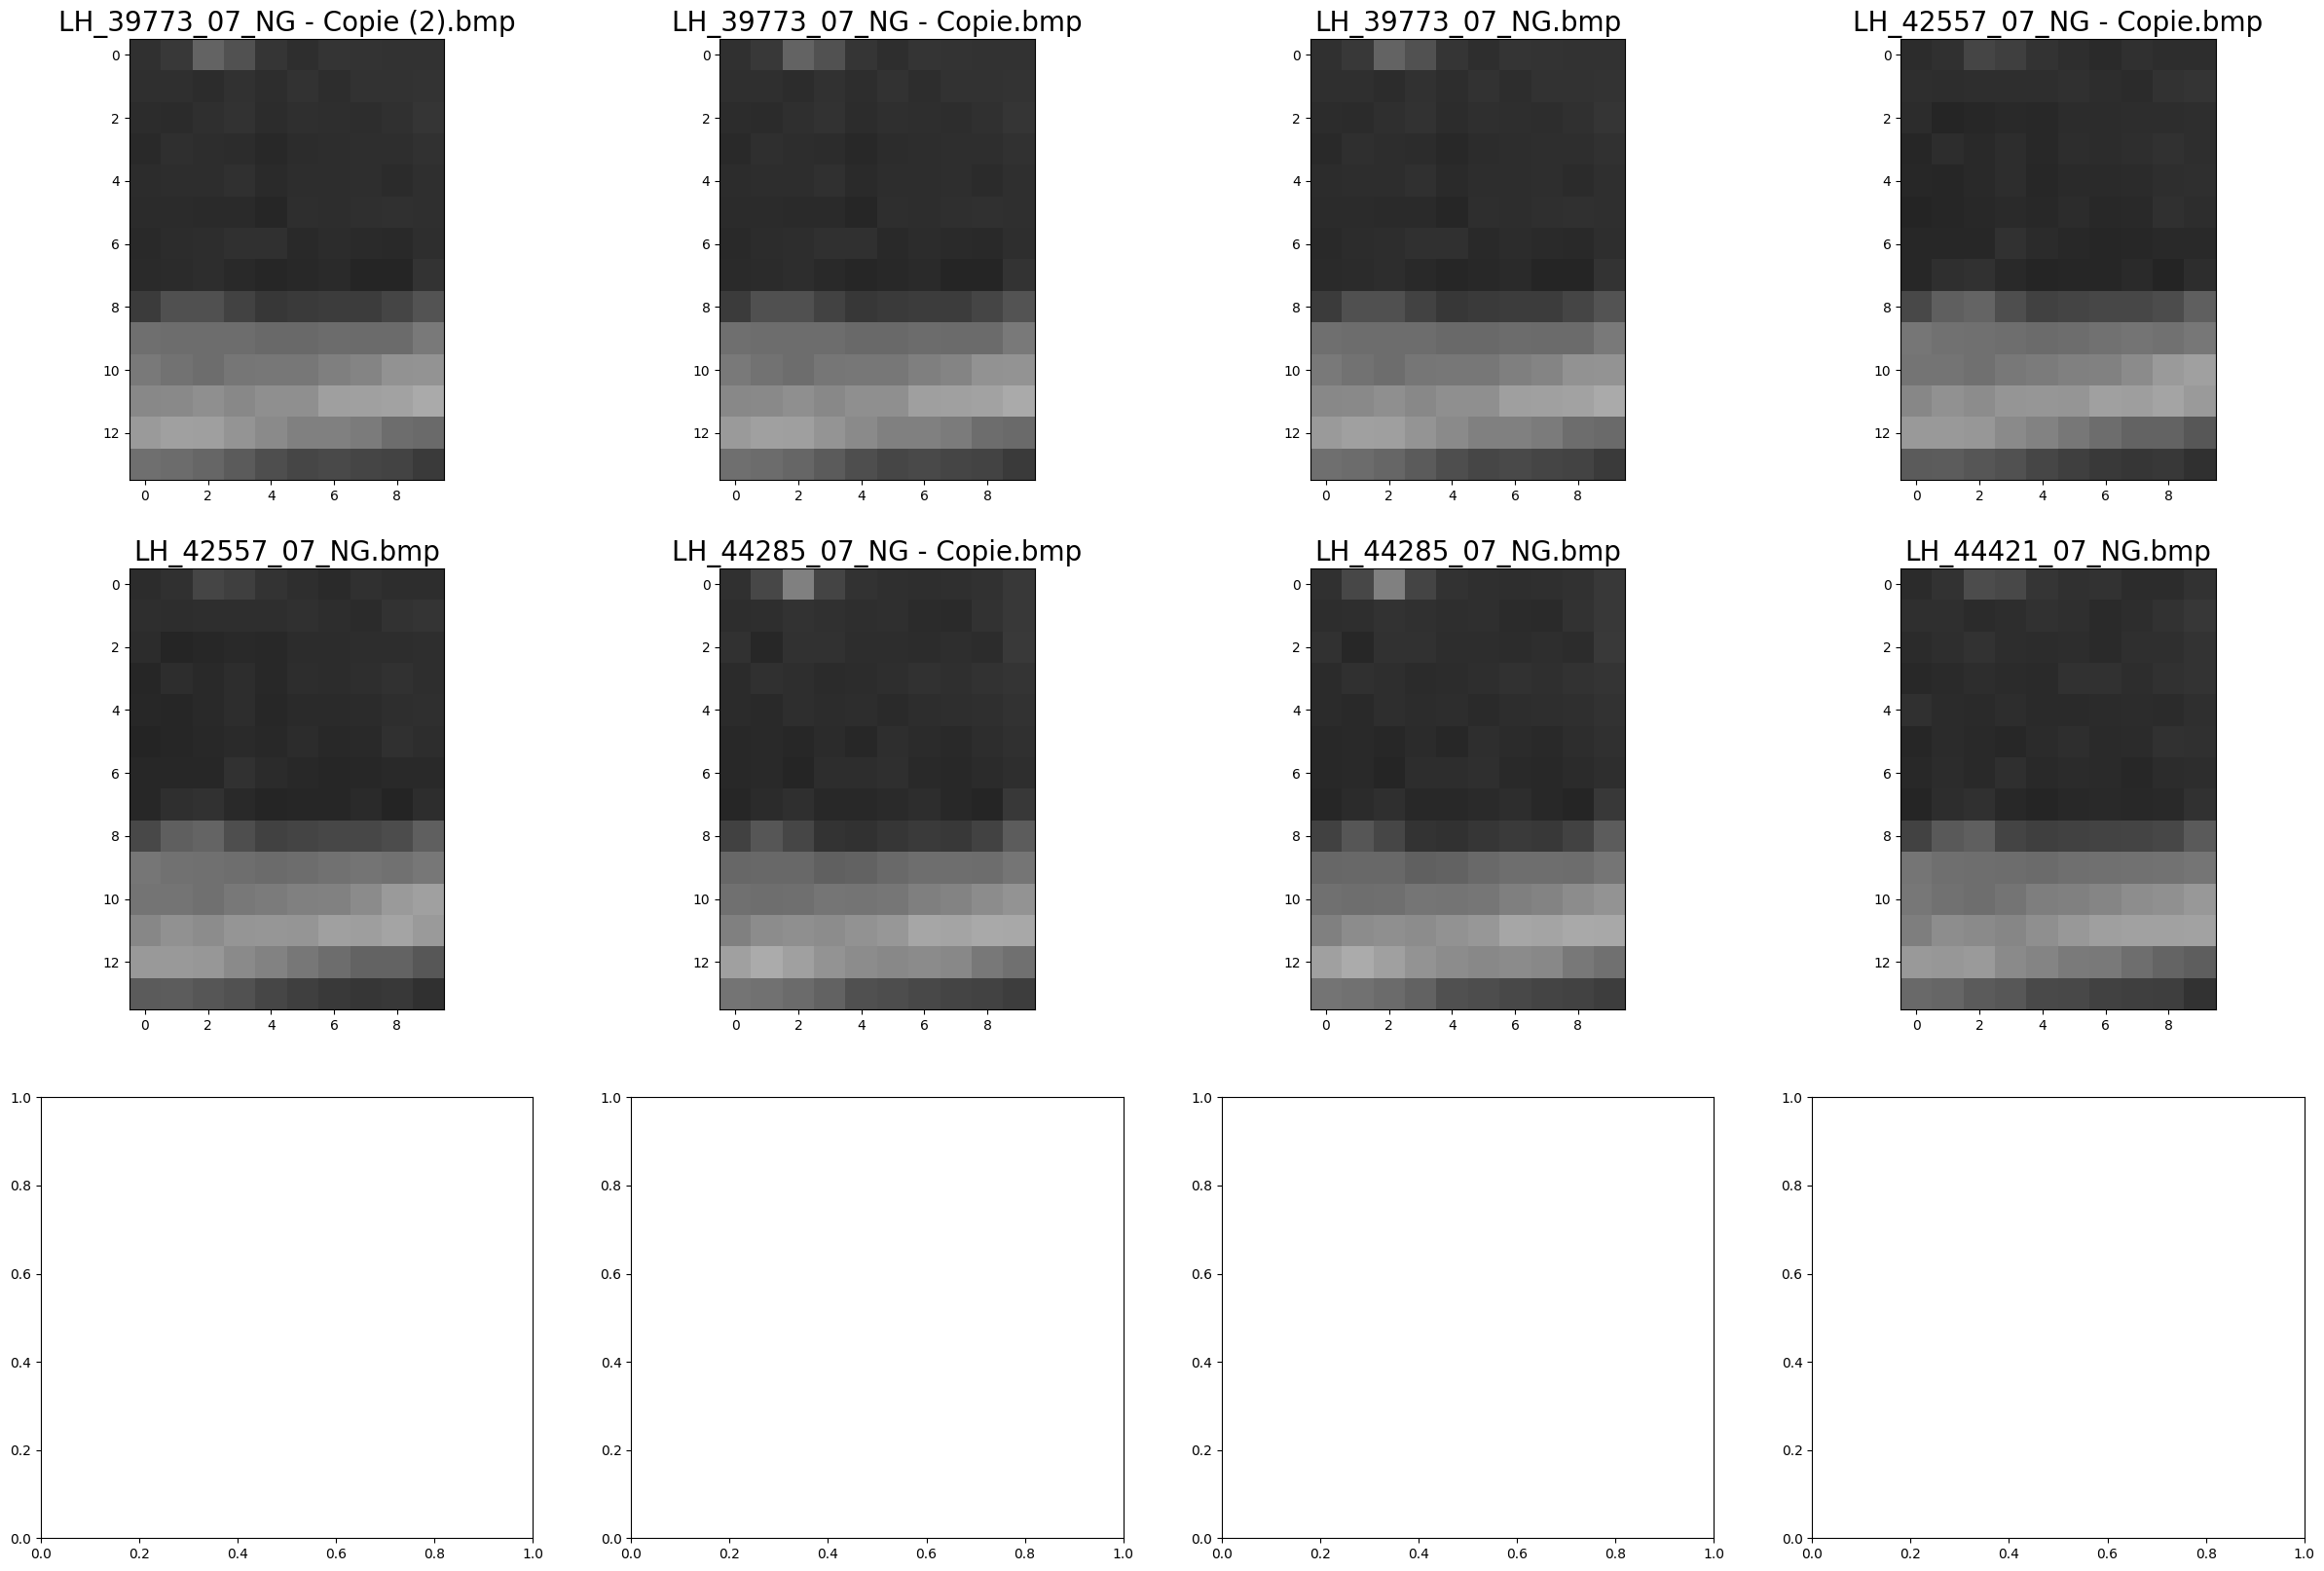

In [15]:
%%time
# Visualisons les images de zones de défaut pour l'entraînement
fig, ax = plt.subplots(1 + len(LISTE_DEFAUT) // 4, 4, figsize=(30, 20))
ax = ax.flatten()
for idx, path in enumerate(LISTE_DEFAUT):
    img = os.path.join(DATA_CROP_TRAIN, "NC", path)
    # assert img est une image
    ax[idx].imshow(plt.imread(img))
    ax[idx].set_title(path, fontsize=20)

In [16]:
# Test
assert len(os.listdir(os.path.join(DATA, "C"))) == len(
    os.listdir(os.path.join(DATA_CROP_TRAIN, "C"))
), print(
    "DATA-C et DATA_CROP_TRAIN-C pas de la même taille ou PREFIX et SUFFIX incorrects à la base"
)
assert len(os.listdir(os.path.join(DATA, "NC"))) == len(
    os.listdir(os.path.join(DATA_CROP_TRAIN, "NC"))
), print(
    "DATA-NC et DATA_CROP_TRAIN-NC pas de la même taille ou PREFIX et SUFFIX incorrects à la base"
)

## Augmentation des données

In [17]:
# Créer un générateur d'images sans augmentation de données
datagen_train = ImageDataGenerator(
    rescale=1.0 / 255,
    brightness_range=[0.75, 2],
    rotation_range=1,
    width_shift_range=False,  # 0.2,
    height_shift_range=False,  # 0.2,
    horizontal_flip=False,
    validation_split=0.25,
    preprocessing_function=preprocess_input,
)

datagen_test = ImageDataGenerator(
    rescale=1.0 / 255,
    height_shift_range=False,
    horizontal_flip=False,
    validation_split=0,
    preprocessing_function=preprocess_input,
)

# Charger les images depuis le répertoire
train_generator = datagen_train.flow_from_directory(
    DATA_CROP_TRAIN,
    target_size=(224, 224),
    batch_size=1,
    class_mode="categorical",
    subset="training",
)

val_generator = datagen_train.flow_from_directory(
    DATA_CROP_TRAIN,
    target_size=(224, 224),
    batch_size=1,
    class_mode="categorical",
    subset="validation",
)

test_generator = datagen_test.flow_from_directory(
    DATA_CROP_TRAIN,
    target_size=(224, 224),
    batch_size=1,
    class_mode="categorical",
    seed=42,
    subset=None,
)

Found 12 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


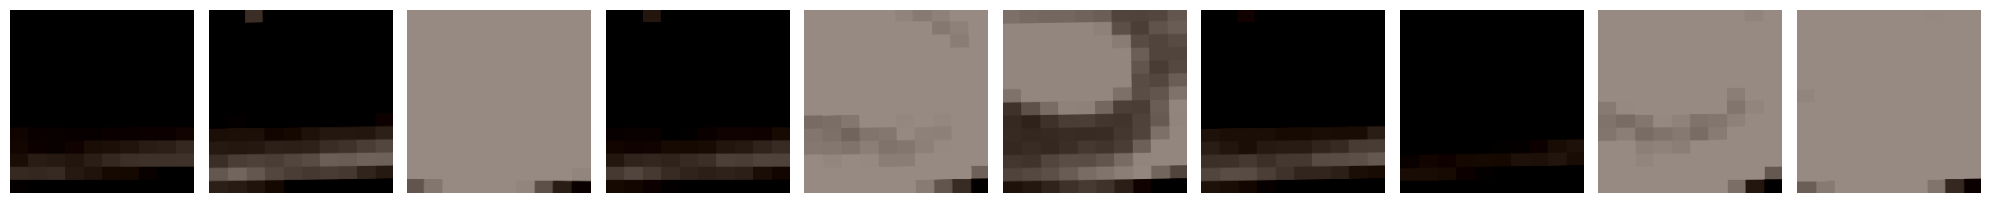

In [18]:
# Visualisons quelques images augmentées
# Fonction pour afficher des images
def plot_images(images_arr):
    fig, axes = plt.subplots(len(images_arr) // 10, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


# Générer et afficher plusieurs lots d'images
num_images_to_display = 10
images_to_display = []

for _ in range(num_images_to_display):
    images, _ = next(train_generator)
    images_to_display.append(images[0])

plot_images(images_to_display)

## Instanciation et entraînement du modèle

In [19]:
# Charger le modèle VGG16 sans les couches supérieures (top layers)
# option 1 : si internet est accessible depuis le notebook
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# option 2 : si internet n'est pas accessible depuis le notebook
# base_model = VGG16(weights="/kaggle/input/weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False, input_shape=(224, 224, 3))

# Figer les couches de base (optionnel)
for layer in base_model.layers:
    layer.trainable = False

for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [20]:
os.makedirs("../models", exist_ok=True)

In [21]:
%%time
# CPU : ATTENTION 243 images en 2mn par epoch => Pour avoir de la GPU voir le Tag dans la barre de droite "Want more power? Access GPU at no cost or turn on an internet connection. Get phone verified"

# Convertir l'input au format list sous le format approprié qui accepte l'attribut shape
img_input = Input(shape=(224, 224, 3))

# test
assert hasattr(img_input, "shape"), print("img_input n'a pas d'attribut shape")

x = base_model(img_input)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(img_input, x, name="vgg16_new_trained")

# Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],  # , "recall"],
)

# Création du callback
model_save_path = f"../models/{MODEL}.keras"
checkpoint = ModelCheckpoint(
    model_save_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min"
)
es = EarlyStopping(monitor="loss", mode="min", verbose=1, patience=5)
callbacks_list = [checkpoint, es]

# Entraîner le modèle
model.fit(
    train_generator, epochs=50, callbacks=callbacks_list, validation_data=val_generator
)

Epoch 1/50


12/12 [==============================] - ETA: 0s - loss: 0.8811 - accuracy: 0.5000
Epoch 1: val_loss improved from inf to 0.39102, saving model to ../models\model_missing_stud_LH07.keras
12/12 [==============================] - 15s 1s/step - loss: 0.8811 - accuracy: 0.5000 - val_loss: 0.3910 - val_accuracy: 1.0000
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.5826 - accuracy: 0.5833
Epoch 2: val_loss improved from 0.39102 to 0.23808, saving model to ../models\model_missing_stud_LH07.keras
12/12 [==============================] - 13s 1s/step - loss: 0.5826 - accuracy: 0.5833 - val_loss: 0.2381 - val_accuracy: 1.0000
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.4745 - accuracy: 0.9167
Epoch 3: val_loss improved from 0.23808 to 0.13272, saving model to ../models\model_missing_stud_LH07.keras
12/12 [==============================] - 12s 1s/step - loss: 0.4745 - accuracy: 0.9167 - val_loss: 0.1327 - val_accuracy: 1.0000
Epoch 4/50
12/12 [====

In [22]:
os.makedirs("../models", exist_ok=True)

In [23]:
# Score du dernier epoch

loss, accuracy = model.evaluate(train_generator, verbose=True)  # , recall
print("Training Accuracy   : {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(val_generator, verbose=True)  # , recall
print("Validation Accuracy :  {:.4f}".format(accuracy))

12/12 [==============================] - 3s 278ms/step - loss: 6.5659e-04 - accuracy: 1.0000
Training Accuracy   : 1.0000
4/4 [==============================] - 1s 270ms/step - loss: 2.5501e-04 - accuracy: 1.0000
Validation Accuracy :  1.0000


In [24]:
# Score de l'epoch optimal

model.load_weights(model_save_path)

loss, accuracy = model.evaluate(val_generator, verbose=False)  # , recall
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(test_generator, verbose=False)  # , recall
print("Test Accuracy       :  {:.4f}".format(accuracy))

Validation Accuracy :  1.0000
Test Accuracy       :  1.0000


In [25]:
# Créer un générateur d'images pour la prédiction
predict_datagen = ImageDataGenerator(
    rescale=1.0 / 255, preprocessing_function=preprocess_input
)

# Spécifiez le répertoire contenant les images pour la prédiction
PREDICT_DIR = DATA_CROP_TRAIN

predict_generator = predict_datagen.flow_from_directory(
    PREDICT_DIR, target_size=(224, 224), batch_size=1, class_mode=None, shuffle=False
)

# Faire les prédictions
predictions = model.predict(predict_generator, steps=len(predict_generator), verbose=1)

# Récupérer les noms de fichiers pour lier les prédictions aux images
filenames = predict_generator.filenames

Found 16 images belonging to 2 classes.
16/16 [==============================] - 5s 265ms/step


In [26]:
liste_defaut_crop = []
for filename, prediction in zip(filenames, predictions):
    predicted_class = np.argmax(prediction)
    if predicted_class == 1:
        liste_defaut_crop.append(os.path.basename(filename))

In [27]:
# test
assert len(liste_defaut_crop) > 0, print("ERREUR : pas de défaut détecté !")
print("nombre de défauts détectés : ", len(liste_defaut_crop))

nombre de défauts détectés :  8


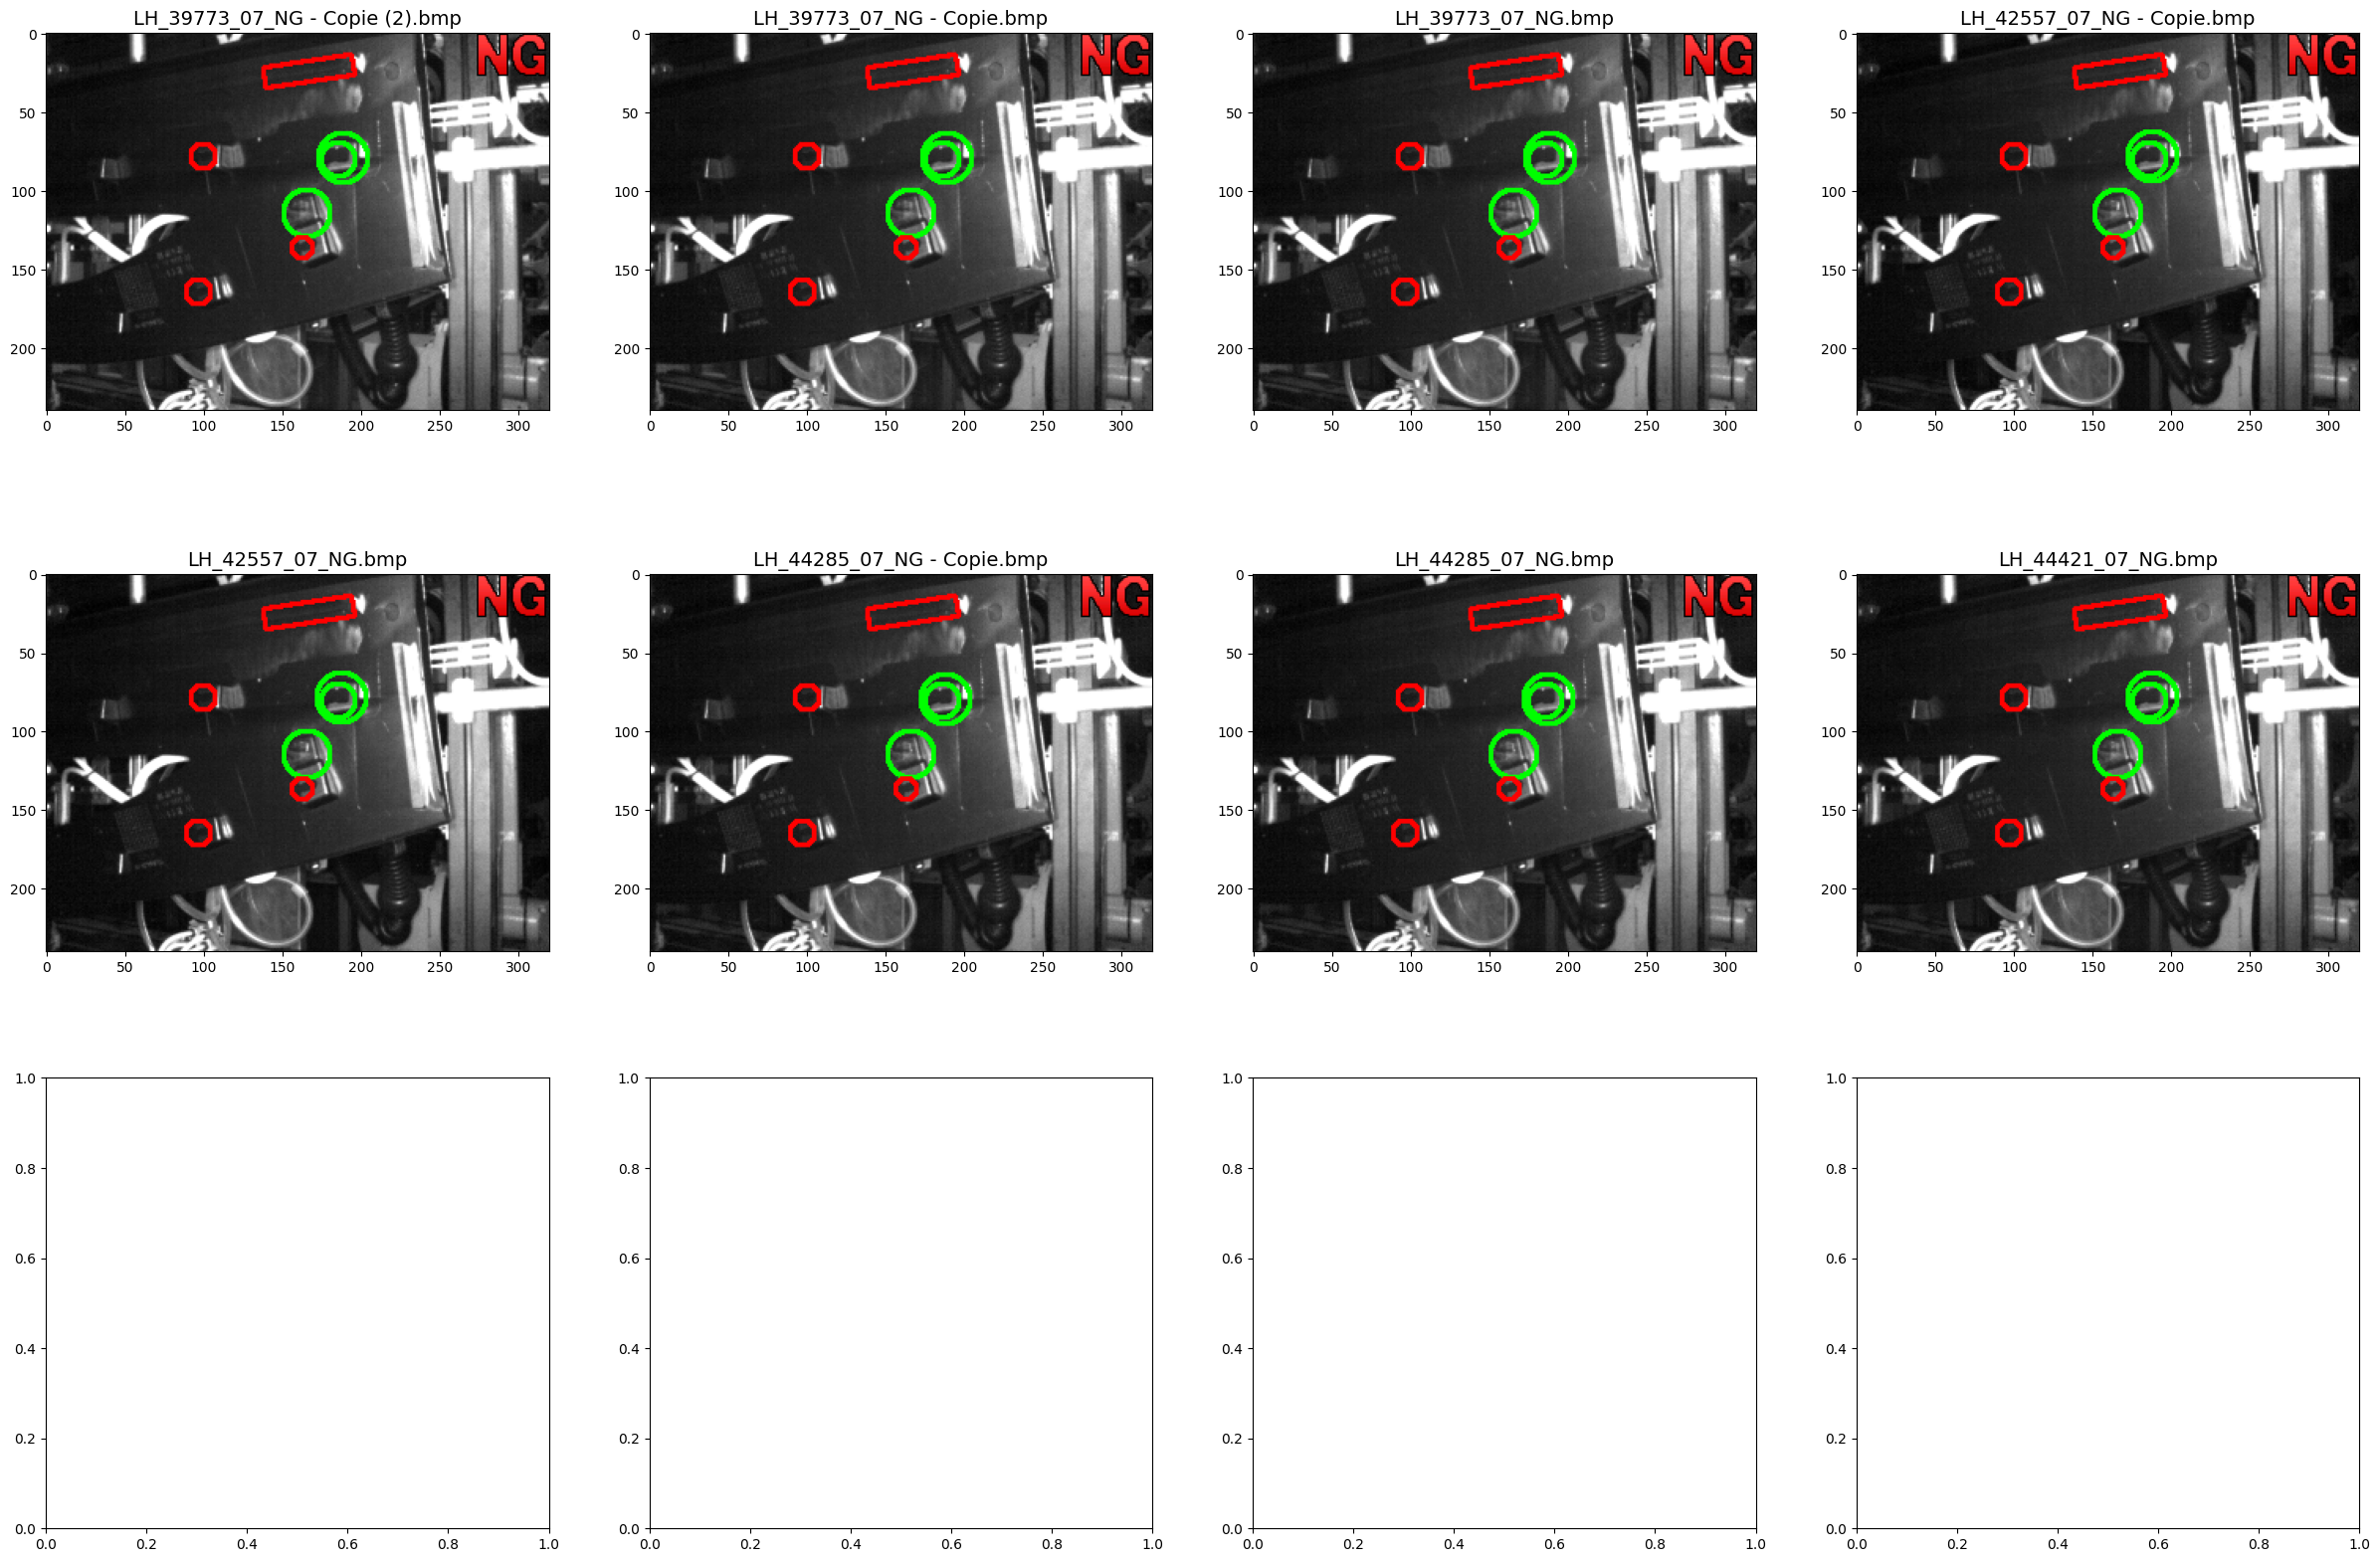

In [28]:
# Visualiser les prédictions de défaut
# Associer chaque fichier d'image à sa prédiction

idx = 0
fig, ax = plt.subplots(1 + len(liste_defaut_crop) // 4, 4, figsize=(30, 20))
ax = ax.flatten()
for file in glob.glob(f"{DATA}/*/*.bmp"):
    name = os.path.basename(file)
    if name in liste_defaut_crop:
        ax[idx].imshow(plt.imread(file))
        ax[idx].set_title(name, fontsize=14)
        idx += 1

In [29]:
# Matrice de confusion
y_true = []
y_pred = []

for img in os.listdir(DATA + r"/C") + os.listdir(DATA + r"/NC"):
    if img in LISTE_DEFAUT:
        y_true.append(1)
    else:
        y_true.append(0)

    if img in liste_defaut_crop:
        y_pred.append(1)
    else:
        y_pred.append(0)

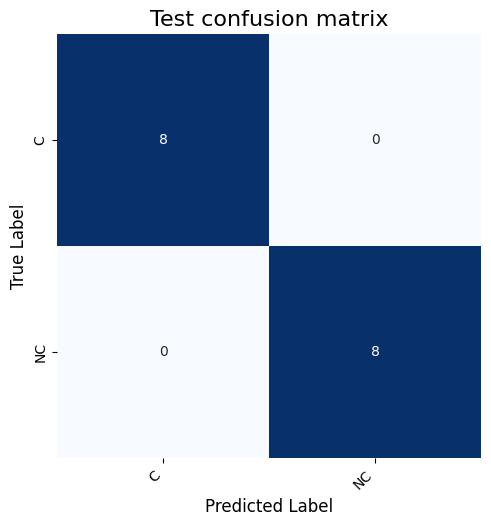

In [30]:
class_names = test_generator.class_indices.keys()


def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt="d",
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax,
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel("True Label", fontsize=12)
    ax.set_xlabel("Predicted Label", fontsize=12)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

plot_heatmap(y_true, y_pred, class_names, ax, title="Test confusion matrix")

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [31]:
# Les faux positifs
FP = set(liste_defaut_crop) - set(LISTE_DEFAUT)
if len(FP) > 0:
    fig, ax = plt.subplots(1 + len(FP) // 3, 3, figsize=(5, 5))
    ax = ax.flatten()
    for idx, img in enumerate(FP):
        ax[idx].imshow(plt.imread(glob.glob(f"{DATA}/*/{img}")[0]))

In [32]:
# Les faux négatifs
FN = set(LISTE_DEFAUT) - set(liste_defaut_crop)
if len(FN) > 0:
    fig, ax = plt.subplots(1 + len(FN) // 3, 3, figsize=(10, 5))
    ax = ax.flatten()
    for idx, img in enumerate(FN):
        ax[idx].imshow(plt.imread(glob.glob(f"{DATA}/*/{img}")[0]))
        ax[idx].set_title(img)

In [33]:
# Zipper le modèle
# Spécifie le chemin du fichier à zipper et le nom du fichier zip résultant
fichier_a_zipper = model_save_path
fichier_zip = f"../data/{MODEL}.zip"

# Crée un fichier ZIP et ajoute le fichier modèle
with zipfile.ZipFile(fichier_zip, "w") as zipf:
    zipf.write(fichier_a_zipper, arcname=f"{MODEL}.keras")

# Vérifie le contenu du répertoire de travail pour confirmer la création du fichier zip
import os

os.listdir("../data")

['archive',
 'DATA_CROP_TRAIN',
 'model_missing_stud_LH07.zip',
 'train_missing_stud_LH07']

In [34]:
# Mettre à disposition le modèle zippé
%cd ..
from IPython.display import FileLink

FileLink(f"data/{MODEL}.zip")

C:\Users\John\Desktop\LFP 070724


C:\Users\John\Desktop\LFP 070724\venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


C:\Users\John\Desktop\LFP 070724\data\model_missing_stud_LH07.zip